In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import tensorflow as tf
import os
import PIL
import pathlib

In [2]:
df = pd.read_csv('./dataset/train.csv')
df['Id'] = './dataset/train/' + df['Id'] + '.jpg'
df['Constant'] = 1
df.head(2)

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,Constant
0,./dataset/train/0007de18844b0dbbb5e1f607da0606...,0,1,1,1,0,0,1,0,0,0,0,0,63,1
1,./dataset/train/0009c66b9439883ba2750fb825e1d7...,0,1,1,0,0,0,0,0,0,0,0,0,42,1


In [3]:
TRAIN_VAL_SPLIT_INDEX = int(0.9 * df.shape[0])
df = df.sample(frac=1.0)
train_df = df.iloc[ : TRAIN_VAL_SPLIT_INDEX]
val_df = df.iloc[TRAIN_VAL_SPLIT_INDEX : ]

In [4]:
train_img_names = train_df.pop('Id').to_numpy()
train_targets = train_df.pop('Pawpularity').to_numpy()

val_img_names = val_df.pop('Id').to_numpy()
val_targets = val_df.pop('Pawpularity').to_numpy()

In [5]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices(( train_df.to_numpy(dtype='int8'), train_targets ))
train_dataset = train_dataset.shuffle(100).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices(( val_df.to_numpy(dtype='int8'), val_targets ))
val_dataset = val_dataset.shuffle(100).batch(batch_size)

In [6]:
HPO_N_HIDDEN_LAYERS = 2

In [7]:
model = tf.keras.Sequential()

model.add(tf.keras.Input(shape=(train_df.shape[1],), name='tabular'))

for _ in range(HPO_N_HIDDEN_LAYERS):
    model.add(tf.keras.layers.Dense(4, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Rescaling(100))


model.compile(
    optimizer = 'adam',
    loss = 'mean_squared_error'
)

In [8]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

Epoch 1/5
279/279 [==============================] - 1s 2ms/step - loss: 739.0972 - val_loss: 539.3665
Epoch 2/5
279/279 [==============================] - 0s 894us/step - loss: 514.4437 - val_loss: 479.3109
Epoch 3/5
279/279 [==============================] - 0s 1ms/step - loss: 456.9165 - val_loss: 455.5505
Epoch 4/5
279/279 [==============================] - 0s 981us/step - loss: 435.3172 - val_loss: 452.7981
Epoch 5/5
279/279 [==============================] - 0s 869us/step - loss: 429.6636 - val_loss: 451.9454


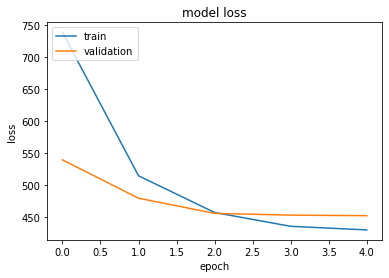

In [9]:
def plot_hist(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(history)

# Building and predicting on Test set

In [12]:
test_df = pd.read_csv('./dataset/test.csv')
test_img_ids = test_df['Id'].copy()
test_df['Id'] = './dataset/test/' + test_df['Id'] + '.jpg'
test_df['Constant'] = 1
test_img_names = test_df.pop('Id').to_numpy()

test_dataset = tf.data.Dataset.from_tensor_slices(test_df.to_numpy(dtype='int8'))
test_dataset = test_dataset.batch(batch_size)

In [13]:
predictions = model.predict(test_dataset)

In [15]:
final = pd.DataFrame()
final['Id'] = test_img_ids
final['Pawpularity'] = predictions
final.to_csv('submission.csv', index=False)

final.Pawpularity.mean()

44.00602

In [16]:
final.head(10)

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,47.985527
1,43a2262d7738e3d420d453815151079e,37.906883
2,4e429cead1848a298432a0acad014c9d,43.870655
3,80bc3ccafcc51b66303c2c263aa38486,39.435371
4,8f49844c382931444e68dffbe20228f4,49.753605
5,b03f7041962238a7c9d6537e22f9b017,51.149822
6,c978013571258ed6d4637f6e8cc9d6a3,46.071972
7,e0de453c1bffc20c22b072b34b54e50f,35.874310
